In [70]:
############################ PREPARATION ############################

#-------------------------- import packages --------------------------
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from itertools import combinations, product
import pyreadr
import seaborn as sns
import copy

import tensorflow as tf
import tensorflow_lattice as tfl
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Layer, CategoryEncoding, Activation
from keras.constraints import Constraint
from keras.callbacks import EarlyStopping
from keras.initializers import Zeros, Constant
from keras.optimizers.legacy import Adam, Nadam, RMSprop
from keras.models import clone_model
import keras_tuner as kt
from keras import backend as K
from keras import regularizers
from keras.utils import plot_model
from keras.losses import Poisson, Loss
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError

# import xgboost as xgb
from scipy.stats import uniform, randint
from pygam import PoissonGAM, GAM, s, f, l, te # s for spline, f for factor, l for linear, te for tensor product
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import make_scorer
from interpret.glassbox import ExplainableBoostingRegressor

import warnings
warnings.filterwarnings('ignore') # suprress warnings

In [71]:
#-------------------------- for reproducibility --------------------------
seed_value = 2000
keras.utils.set_random_seed(seed_value)
np.random.seed(seed_value)

In [72]:
#-------------------------- import data --------------------------
''' Belgian motor third-party liability dataset from the CAS collection '''
r_data = pyreadr.read_r("data/beMTPL97.rda")
data = r_data['beMTPL97']
data.head() # view data snapshot

,id,expo,claim,nclaims,amount,average,coverage,ageph,sex,bm,power,agec,fuel,use,fleet,postcode,long,lat
0,1,1.000000,1,1,1618.001036,1618.001036,TPL,50,male,5,77,12,gasoline,private,0,1000,4.355223,50.845386
1,2,1.000000,0,0,0.000000,NaN,TPL+,64,female,5,66,3,gasoline,private,0,1000,4.355223,50.845386
2,3,1.000000,0,0,0.000000,NaN,TPL,60,male,0,70,10,diesel,private,0,1000,4.355223,50.845386
3,4,1.000000,0,0,0.000000,NaN,TPL,77,male,0,57,15,gasoline,private,0,1000,4.355223,50.845386
4,5,0.046575,1,1,155.974606,155.974606,TPL,28,female,9,70,7,gasoline,private,0,1000,4.355223,50.845386


In [73]:
############################ DATA UNDERSTANDING & CLEANING ############################

#-------------------------- high-level checking --------------------------
print(data.shape) # number of rows and columns
print(data.info()) # check data type and missing values

(163212, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163212 entries, 0 to 163211
Data columns (total 18 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   id        163212 non-null  int32   
 1   expo      163212 non-null  float64 
 2   claim     163212 non-null  category
 3   nclaims   163212 non-null  int32   
 4   amount    163212 non-null  float64 
 5   average   18276 non-null   float64 
 6   coverage  163212 non-null  category
 7   ageph     163212 non-null  int32   
 8   sex       163212 non-null  category
 9   bm        163212 non-null  int32   
 10  power     163212 non-null  int32   
 11  agec      163212 non-null  int32   
 12  fuel      163212 non-null  category
 13  use       163212 non-null  category
 14  fleet     163212 non-null  category
 15  postcode  163212 non-null  int32   
 16  long      163212 non-null  float64 
 17  lat       163212 non-null  float64 
dtypes: category(6), float64(5), int32(7)
memory usage: 

In [74]:
#-------------------------- filter claim data --------------------------
claim = data.drop(columns = ["id","claim","amount","average","postcode"]).reset_index(drop = True) # filter positive claims and remove unnecessary columns
print(f"{claim.shape[0]} rows and {claim.shape[1]} columns")
claim.head()

163212 rows and 13 columns


,expo,nclaims,coverage,ageph,sex,bm,power,agec,fuel,use,fleet,long,lat
0,1.000000,1,TPL,50,male,5,77,12,gasoline,private,0,4.355223,50.845386
1,1.000000,0,TPL+,64,female,5,66,3,gasoline,private,0,4.355223,50.845386
2,1.000000,0,TPL,60,male,0,70,10,diesel,private,0,4.355223,50.845386
3,1.000000,0,TPL,77,male,0,57,15,gasoline,private,0,4.355223,50.845386
4,0.046575,1,TPL,28,female,9,70,7,gasoline,private,0,4.355223,50.845386


In [75]:
#-------------------------- descriptive statistics for numeric columns --------------------------
claim[["expo","nclaims","ageph","bm","power","agec","long","lat"]].describe()

,expo,nclaims,ageph,bm,power,agec,long,lat
count,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000,163212.000000
mean,0.889744,0.123857,47.000950,3.268246,56.002978,7.374923,4.407262,50.758422
std,0.244202,0.367471,14.831561,3.998171,19.024828,4.206447,0.751036,0.317856
min,0.002740,0.000000,18.000000,0.000000,10.000000,0.000000,2.577787,49.536246
25%,1.000000,0.000000,35.000000,0.000000,43.000000,4.000000,3.879313,50.516333
50%,1.000000,0.000000,46.000000,1.000000,53.000000,7.000000,4.387146,50.771932
75%,1.000000,0.000000,58.000000,6.000000,66.000000,10.000000,4.874195,50.994654
max,1.000000,5.000000,95.000000,22.000000,243.000000,48.000000,6.305543,51.449816


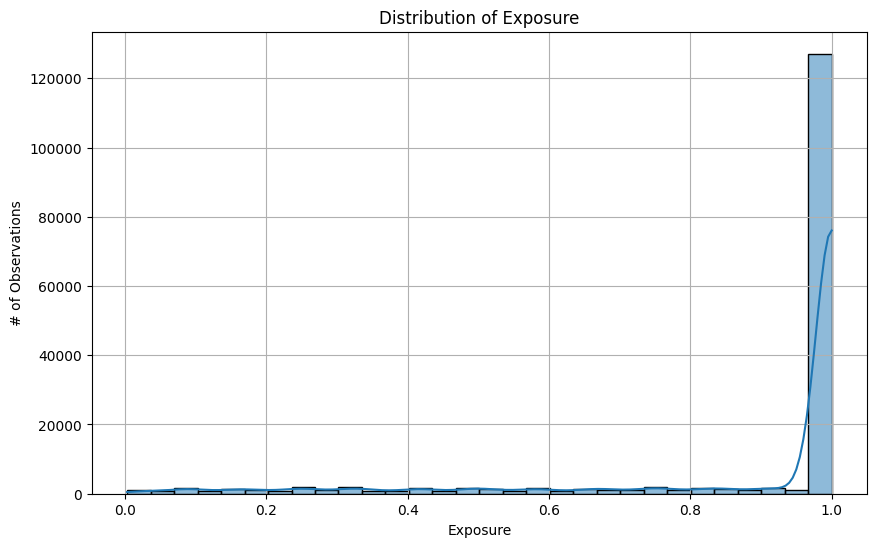

In [76]:
#-------------------------- distribution of claim amount --------------------------
plt.figure(figsize = (10, 6)) # set the size of the figure
sns.histplot(claim['expo'], bins = 30, kde = True) # draw the chart
plt.title('Distribution of Exposure')
plt.xlabel('Exposure')
plt.ylabel('# of Observations')
plt.grid(True)
plt.show()

In [77]:
### function to get the summary of number of instances per distinct category for categorical variable
def get_summary(data, column):
    summary = data[column].value_counts().reset_index()
    summary.columns = [column, 'Count']
    return summary

In [78]:
#-------------------------- check the distribution of categorical variables --------------------------
# get the categorical variables
cat_vars = ["coverage", "sex", "fuel", "use", "fleet"]
num_vars = ["ageph", "bm", "power", "agec", "long", "lat"] # numerical variables
all_vars = ["expo"] + cat_vars + num_vars

# get the distributions of categorical and target variables
summary_tables = {}
for column in ["nclaims"] + cat_vars:
    summary = get_summary(claim, column)
    summary_tables[column] = summary

# display the summary tables
for column, summary in summary_tables.items():
    print(f"{column} Summary:\n", summary, "\n")

nclaims Summary:
    nclaims   Count
0        0  144936
1        1   16539
2        2    1556
3        3     162
4        4      17
5        5       2 

coverage Summary:
   coverage  Count
0      TPL  95124
1     TPL+  45984
2    TPL++  22104 

sex Summary:
       sex   Count
0    male  120044
1  female   43168 

fuel Summary:
        fuel   Count
0  gasoline  112818
1    diesel   50394 

use Summary:
        use   Count
0  private  155334
1     work    7878 

fleet Summary:
   fleet   Count
0     0  158041
1     1    5171 



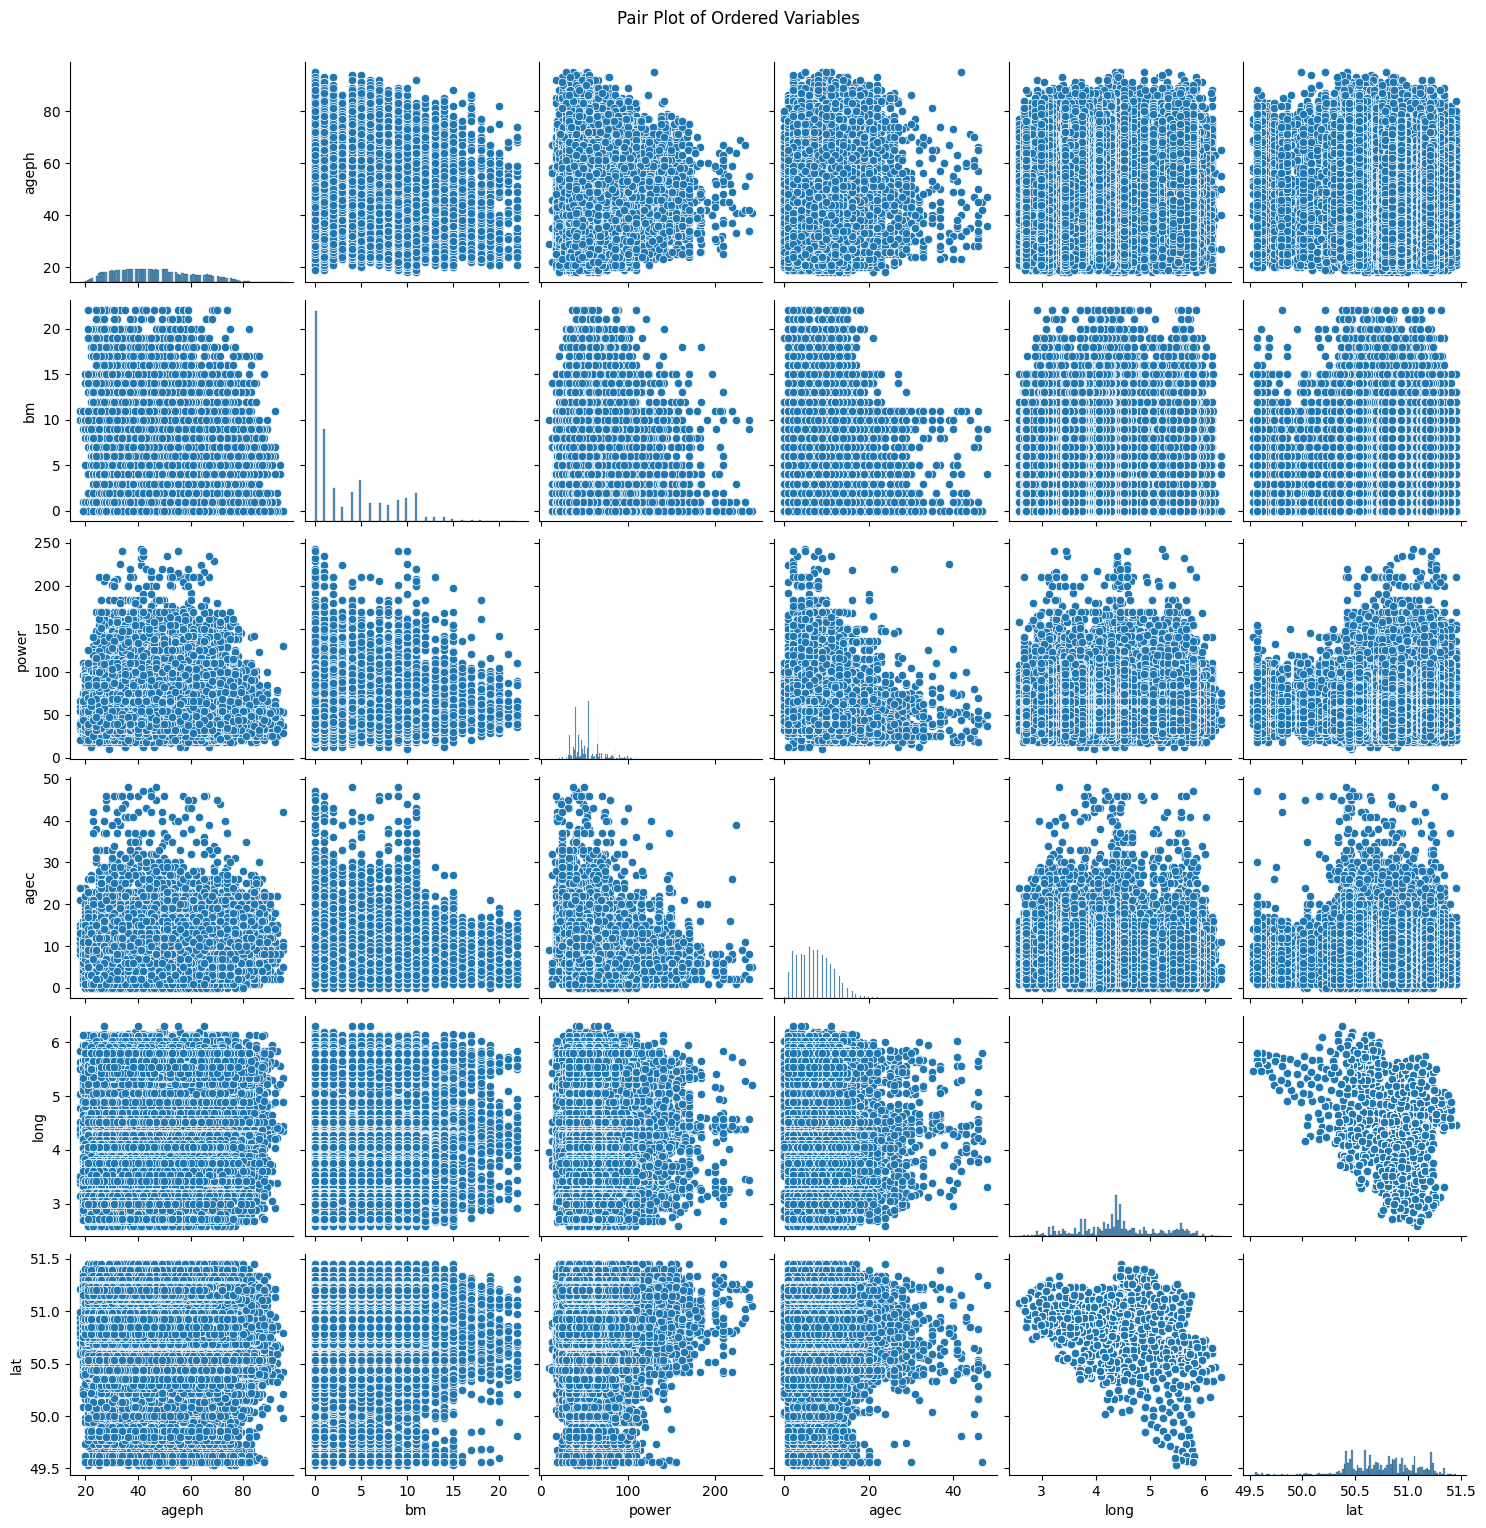

In [79]:
# -------------------------- check distribution of continuous and ordinal variables --------------------------
# Create pair plots for the specified variables
sns.pairplot(claim[num_vars])
plt.suptitle('Pair Plot of Ordered Variables', y = 1.02)
plt.show()

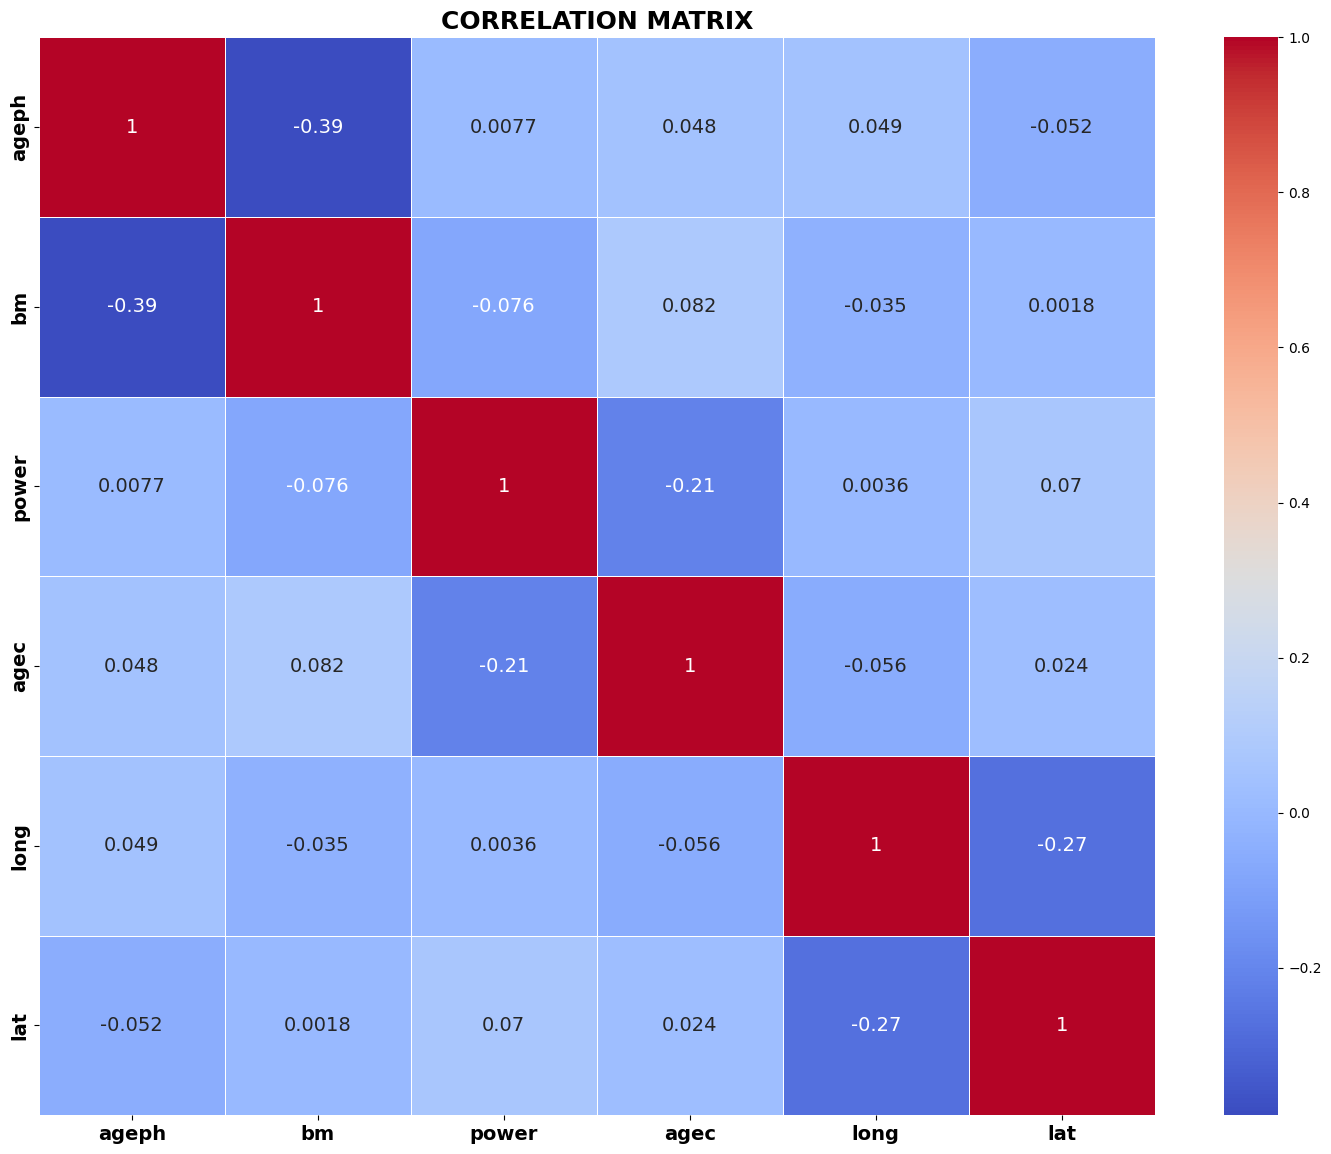

In [80]:
#-------------------------- check correlations of numeric variables --------------------------
correlation_matrix = claim[num_vars].corr() # correlation matrix

# plot the heatmap
plt.figure(figsize = (18, 14))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', linewidths = 0.5, annot_kws = {"size":14})
plt.title('CORRELATION MATRIX', fontsize = 18, fontweight = 'bold')
plt.xticks(fontsize = 14, fontweight = 'bold')
plt.yticks(fontsize = 14, fontweight = 'bold')
plt.show()

In [81]:
#-------------------------- train-test split --------------------------
target_var = "nclaims"
X_main, X_test, y_main, y_test = train_test_split(
    claim[all_vars], claim[target_var], test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val  = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

In [82]:
#-------------------------- variable encoding --------------------------
# define transformer
ct = make_column_transformer(
    ("passthrough", ["expo"]),
    (OrdinalEncoder(), cat_vars),
    remainder = StandardScaler(),
    verbose_feature_names_out = False
)

# fit & transform
train = ct.fit_transform(X_train)
val = ct.fit_transform(X_val)
test = ct.transform(X_test)
feature_names = ct.get_feature_names_out()  # get the columns' names
feature_names

array(['expo', 'coverage', 'sex', 'fuel', 'use', 'fleet', 'ageph', 'bm',
       'power', 'agec', 'long', 'lat'], dtype=object)

In [83]:
############################ NEURAL ADDITIVE MODEL ############################

# -------------------------- create custom layer and subnetwork --------------------------
# subnetwork for numerical variables
def create_subnet(num_layers, units_per_layer, activation, model_name, dropout_rate = 0, trainable = True, seed = 1):
    model = Sequential(name = model_name)
    for _ in range(num_layers):
        model.add(Dense(units_per_layer, activation = activation, trainable = trainable))
        model.add(Dropout(dropout_rate, seed = seed))
    model.add(Dense(1, trainable = trainable))
    model.add(BatchNormalization(scale = False)) # for identifiability
    return model

# layer to add all subnets' outputs and a bias term
@keras.saving.register_keras_serializable()
class AddSubnetOutput(Layer):
    def __init__(self, activation = None, **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.bias = self.add_weight(
            shape = (1,), initializer = 'zeros', trainable = True, name = 'bias'
        )   
    def call(self, inputs):
        subnet_sum = K.sum(inputs, axis = -1, keepdims = True)
        output = subnet_sum + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

# helper function to add calibrator layer
def add_calibrate_layer(var, other_var, data, monotonicity_list, lattice_sizes, keypoints, cat_vars, lattice_smooth_reg = [0,0]):
    if var in cat_vars:
        calibrator_layer = tfl.layers.CategoricalCalibration(
            num_buckets = data[var].nunique(),
            output_min = 0,
            output_max = lattice_sizes[var] - 1,
            name = f"{var}_calibrator_pairwise_{var}_{other_var}"
        )
    else:
        calibrator_layer = tfl.layers.PWLCalibration(
            input_keypoints =  np.linspace(data[var].min(), data[var].max(), num = keypoints), # keypoints
            kernel_regularizer = ('hessian', lattice_smooth_reg[0], lattice_smooth_reg[1]), # for smoothness
            monotonicity = monotonicity_list[var] if var in monotonicity_list else "none", # monotonicity constraint
            output_min = 0,
            output_max = lattice_sizes[var] - 1,
            name = f"{var}_calibrator_pairwise_{var}_{other_var}"
            )
    return calibrator_layer

In [84]:
# -------------------------- custom constraint--------------------------
# function to add smoothness penalty
def make_smoothness_penalty(var, data, model, lambd_smooth, grid_length, imp_vars):
    # Create input grid as TensorFlow tensors
    grid_min = tf.constant(data[var].min(), dtype = tf.float32)
    grid_max = tf.constant(data[var].max(), dtype = tf.float32)
    grid = tf.linspace(grid_min, grid_max, grid_length)
    grid = tf.reshape(grid, (-1, 1))  # Ensure grid is a column vector

    # Prepare inputs for the model
    grid_inputs = []
    for feature in imp_vars:
        if feature == var:
            grid_inputs.append(grid)
        else:
            # Use zeros_like to match the shape of grid
            grid_inputs.append(tf.zeros_like(grid))

    # Define a zero-argument function to compute the penalty
    def smoothness_penalty():
        # Get the prediction
        f = model(grid_inputs)[:, imp_vars.index(var)]
        f = tf.reshape(f, (-1,))  # Flatten to 1D tensor for slicing

        # Calculate the second derivative using finite differences
        h = (grid_max - grid_min) / (grid_length - 1)
        h_squared = h ** 2
        f_plus = f[2:]      # f(x + h)
        f_minus = f[:-2]    # f(x - h)
        f_current = f[1:-1] # f(x)

        # Second derivative approximation
        second_derivative = (f_plus + f_minus - 2 * f_current) / h_squared

        # Compute the penalty
        penalty = lambd_smooth * K.mean(tf.abs(second_derivative))
        return penalty
    
    return smoothness_penalty

In [85]:
#-------------------------- prepare the data for NAM --------------------------
X_train_split = []
X_val_split = []
for i in range(train.shape[1]):
    X_train_split.append(train[:, i])
    X_val_split.append(val[:, i])

In [86]:
# -------------------------- Fit an ensemble of 10 NAMs --------------------------
seed = 0
num_models = 10
all_variance = []

# create ensemble and get subnet variance
for i in range(num_models):
    
    keras.utils.set_random_seed(seed)

    # -------------------------- hyperparameters --------------------------
    inputs = []  # input layers
    sub_outputs_main = []  # main effect subnet output
    num_neurons_main = 10
    num_layers_main = 2
    activation = 'leaky_relu'
    keypoints = 10
    monotonicity_list = {"bm" : "increasing"} # either "increasing", "decreasing", or "none"


    # -------------------------- model architecture --------------------------
    # main effect
    for name in all_vars:
        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)

        # subnetworks for main effects
        if name == "expo":  # Direct use without a subnet
            exposure_input = input_layer
        elif name in cat_vars: # categorical variables
            # categorical variables will be one-hot encoded
            embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                    output_dim = 1, 
                                    name = f"{name}_embed")(input_layer)
            embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(embed_layer_reshape)
            sub_outputs_main.append(mean_layer)
        elif name in monotonicity_list: # variables with monotonicity constraint
            calibrator_layer = tfl.layers.PWLCalibration(
                input_keypoints =  np.linspace(X_train[name].min(), X_train[name].max(), num = keypoints), # keypoints
                monotonicity = monotonicity_list[name], # monotonicity constraint
                name = f"{name}_pwlcalibrator"
            )(input_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(calibrator_layer)
            sub_outputs_main.append(mean_layer)
        else: # numeric variables
            subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
            sub_output = subnet(input_layer)
            sub_outputs_main.append(sub_output)

    # combine subnets' outputs
    main_subnets = Concatenate(name = "main_subnet")(sub_outputs_main)
    sum_output = AddSubnetOutput(activation = 'exponential',
                        name = "main_output")(main_subnets) # claim frequency per unit of exposure
    final_output = Multiply(name = "final_output")([exposure_input, sum_output])

    # model
    model_all_vars = Model(inputs = inputs, outputs = final_output)


    # -------------------------- fit the model --------------------------
    model_all_vars.compile(optimizer = "rmsprop", loss = "poisson", metrics = ["poisson", RootMeanSquaredError(), MeanAbsoluteError()])
    es = EarlyStopping(restore_best_weights = True, patience = 10)
    model_all_vars.fit(X_train_split, y_train, epochs = 5_000, \
        callbacks = [es], batch_size = 2_000, validation_data = (X_val_split, y_val), verbose = 0)
    

    # -------------------------- quantify variable importance --------------------------
    main_output_layer = model_all_vars.get_layer("main_subnet")  # Get the subnet output layer
    main_model = Model(inputs = model_all_vars.inputs, outputs = main_output_layer.output)
    main_output_values = main_model.predict(X_train_split, batch_size = 2_000)

    # Get the variance of each subnetwork across all data points
    subnet_variance = [np.var(main_output_values[:, i]) for i in range(main_output_values.shape[1])]
    all_variance.append(subnet_variance)

    # update seed
    seed += 1

49/49 [==============================] - 0s 900us/step


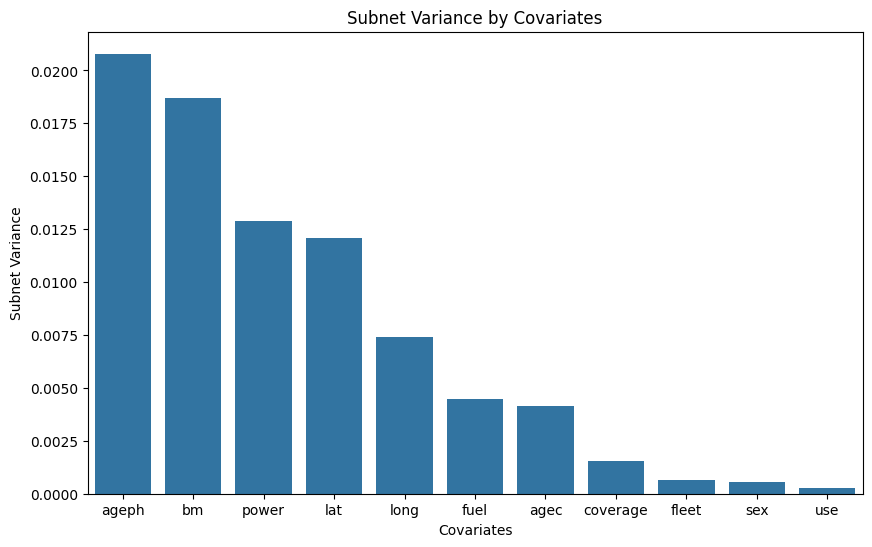

In [87]:
# -------------------------- plot the variable importance --------------------------
average_variances = np.mean(all_variance, axis = 0) # get the average variance
covariates = [name for name in cat_vars + num_vars] # get variable name

# Create DataFrame for variable importance
var_importance = pd.DataFrame({"Covariates": covariates, "Subnet Variance": average_variances})

# Sort the DataFrame by subnet variance in decreasing order
varimp_sorted = var_importance.sort_values(by = "Subnet Variance", ascending = False)

# Create a bar plot using Seaborn
plt.figure(figsize = (10, 6))
sns.barplot(x = "Covariates", y = "Subnet Variance", data = varimp_sorted)
plt.title("Subnet Variance by Covariates")
plt.xlabel("Covariates")
plt.ylabel("Subnet Variance")
plt.show()

In [88]:
#-------------------------- reset keras seed --------------------------
keras.utils.set_random_seed(seed_value)

In [89]:
#-------------------------- main effect model --------------------------
inputs = []  # input layers
sub_outputs_main = []  # main effect subnet output
num_neurons_main = 10
num_layers_main = 2
activation = 'leaky_relu'
keypoints = 10
monotonicity_list = {"bm" : "increasing"} # either "increasing", "decreasing", or "none"
imp_vars = ["ageph", "bm", "power", "lat", "long", "fuel", "agec"]

# main effect
for name in ["expo"] + imp_vars:
    input_layer = Input(shape = (1,), name = name)
    inputs.append(input_layer)

    # subnetworks for main effects
    if name == "expo":  # Direct use without a subnet
        exposure_input = input_layer
    elif name in cat_vars: # categorical variables
        # categorical variables will be one-hot encoded
        embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                output_dim = 1, 
                                name = f"{name}_embed")(input_layer)
        embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
        mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(embed_layer_reshape)
        sub_outputs_main.append(mean_layer)
    elif name in monotonicity_list: # variables with monotonicity constraint
        calibrator_layer = tfl.layers.PWLCalibration(
            input_keypoints =  np.linspace(X_train[name].min(), X_train[name].max(), num = keypoints), # keypoints
            monotonicity = monotonicity_list[name], # monotonicity constraint
            name = f"{name}_pwlcalibrator"
        )(input_layer)
        mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(calibrator_layer)
        sub_outputs_main.append(mean_layer)
    else: # numeric variables
        subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork")
        sub_output = subnet(input_layer)
        sub_outputs_main.append(sub_output)

# combine subnets' outputs
main_subnets = Concatenate(name = "main_subnet")(sub_outputs_main)
sum_output = AddSubnetOutput(activation = 'exponential',
                    name = "main_effect_sum")(main_subnets) # claim frequency per unit of exposure
final_output = Multiply(name = "main_effect_output")([exposure_input, sum_output])

# model
model_main_effect = Model(inputs = inputs, outputs = final_output)

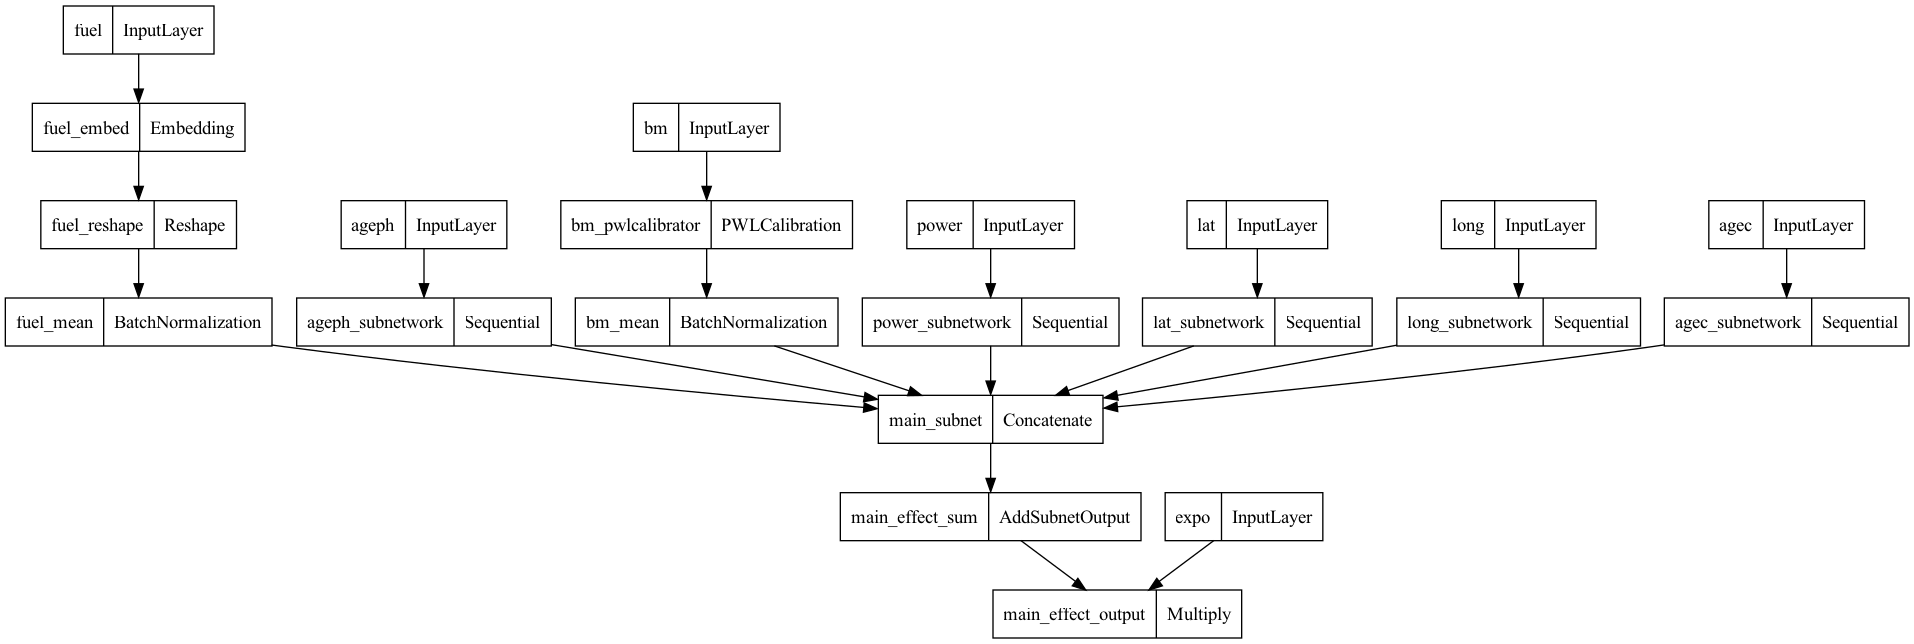

In [90]:
plot_model(model_main_effect)

In [91]:
#-------------------------- data preparation --------------------------
# for NAM
X_train_split = []
X_val_split = []
X_test_split = []
for var in ["expo"] + imp_vars:
    X_train_split.append(train[:, all_vars.index(var)])
    X_val_split.append(val[:, all_vars.index(var)])
    X_test_split.append(test[:, all_vars.index(var)])

# for other models
X_train_imp = train[:,[var in imp_vars for var in feature_names]]
X_val_imp = val[:,[var in imp_vars for var in feature_names]]
X_test_imp = test[:,[var in imp_vars for var in feature_names]]
y_train_transformed = y_train/train[:,0]
y_val_transformed = y_val/val[:,0]
y_test_transformed = y_test/test[:,0]

In [92]:
# #-------------------------- fit NAM with only important main effects --------------------------
model_main_effect.compile(optimizer = "rmsprop", loss = "poisson")
es = EarlyStopping(restore_best_weights = True, patience = 10)
model_main_effect.fit(X_train_split, y_train, epochs = 5_000, \
    callbacks = [es], batch_size = 2_000, validation_data = (X_val_split, y_val))

Epoch 1/5000
49/49 [==============================] - 1s 6ms/step - loss: 2.3379 - val_loss: 0.7336
Epoch 2/5000
49/49 [==============================] - 0s 2ms/step - loss: 0.7154 - val_loss: 0.6056
Epoch 3/5000
49/49 [==============================] - 0s 3ms/step - loss: 0.5241 - val_loss: 0.4916
Epoch 4/5000
49/49 [==============================] - 0s 3ms/step - loss: 0.4439 - val_loss: 0.4132
Epoch 5/5000
49/49 [==============================] - 0s 3ms/step - loss: 0.4003 - val_loss: 0.3917
Epoch 6/5000
49/49 [==============================] - 0s 3ms/step - loss: 0.3826 - val_loss: 0.3780
Epoch 7/5000
49/49 [==============================] - 0s 3ms/step - loss: 0.3791 - val_loss: 0.3769
Epoch 8/5000
49/49 [==============================] - 0s 3ms/step - loss: 0.3782 - val_loss: 0.3742
Epoch 9/5000
49/49 [==============================] - 0s 3ms/step - loss: 0.3789 - val_loss: 0.3797
Epoch 10/5000
49/49 [==============================] - 0s 3ms/step - loss: 0.3778 - val_loss: 0.3787

In [93]:
# -------------------------- get validation loss --------------------------
main_val_loss = model_main_effect.evaluate(X_val_split, y_val, verbose = False) # get the validation loss and RMSE
print(f"Validation loss for main effect: {main_val_loss}")

Validation loss for main effect: 0.3717160224914551


In [94]:
#-------------------------- preparation for interaction selection --------------------------
global_layers = ["main_subnet", "main_effect_sum", "main_effect_output", "interaction_output", "final_output"] # these layers are always trainable
num_layers_interaction = 3 # number of layers for each interaction effect
num_neurons_interaction = 30 # number of neurons per dense layer for each interaction effect
keypoints = 20
interactions = combinations(imp_vars, 2)
interaction_loss = {} # this stores the validation loss when fitting each pair of interaction effect
lattice_sizes_pairwise = {}
for var in imp_vars:
    if var in cat_vars:
        lattice_sizes_pairwise[var] = X_train[var].nunique()
    else:
        lattice_sizes_pairwise[var] = 8

In [95]:
#-------------------------- select interaction effect --------------------------
for var1, var2 in interactions:

    # -------------------------- initialize a cloned model --------------------------
    model_main_cloned = clone_model(model_main_effect) # clone the main effect model
    model_main_cloned.build(model_main_effect.input_shape)
    model_main_cloned.set_weights(model_main_effect.get_weights()) # copy the weights


    # -------------------------- build a subnet for pairwise interaction effect --------------------------
    var1_input = model_main_cloned.inputs[imp_vars.index(var1) + 1]
    var2_input = model_main_cloned.inputs[imp_vars.index(var2) + 1]

    # Lattice model if the pair contains a monotonic variable
    if any(var in monotonicity_list for var in [var1, var2]):
        lattice_inputs = []

        # create calibrator_layer
        calibrator_var1 = add_calibrate_layer(var1, var2, X_train, monotonicity_list, lattice_sizes_pairwise, keypoints, cat_vars)
        calibrator_var2 = add_calibrate_layer(var2, var1, X_train, monotonicity_list, lattice_sizes_pairwise, keypoints, cat_vars)
        calibrator_layer_var1 = calibrator_var1(var1_input)
        calibrator_layer_var2 = calibrator_var2(var2_input)
        
        # lattice
        lattice_inputs.append(calibrator_layer_var1)
        lattice_inputs.append(calibrator_layer_var2)
        lattice_layer = tfl.layers.Lattice(lattice_sizes = [lattice_sizes_pairwise[var1],lattice_sizes_pairwise[var2]], 
                            monotonicities = ["increasing" if var1 in monotonicity_list else 'none',
                                                "increasing" if var2 in monotonicity_list else 'none'],
                            name = f"{var1}_{var2}_lattice")(lattice_inputs)
        pairwise_output = BatchNormalization(scale = False, name = f"{var1}_{var2}_mean")(lattice_layer)
    else:
        # Subnetwork if the pair contains no monotonic variables
        pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
        pairwise_subnet = create_subnet(num_layers_interaction, 
                                        num_neurons_interaction, 
                                        activation, 
                                        f"{var1}_{var2}_subnetwork")
        pairwise_output = pairwise_subnet(pairwise_input_layer)

    # final output
    interaction_subnet_output = Activation('exponential',
                        name = "interaction_output")(pairwise_output)
    main_subnet_output = model_main_cloned.output
    final_output = Multiply(name = "final_output")([main_subnet_output, interaction_subnet_output])
    model_pairwise = Model(inputs = model_main_cloned.inputs, outputs = final_output)


    # -------------------------- switch on/off layers --------------------------
    for layer in model_pairwise.layers:
        if layer.name not in global_layers and var1 not in layer.name and var2 not in layer.name:
            layer.trainable = False

    # -------------------------- compile and train the model --------------------------
    model_pairwise.compile(optimizer = 'rmsprop', 
                        loss = "poisson")
    es = EarlyStopping(patience = 10, restore_best_weights = True)
    model_pairwise.fit(X_train_split, y_train, epochs = 5_000, \
                            callbacks = [es], batch_size = 5_000, validation_data = (X_val_split, y_val))
    val_loss = model_pairwise.evaluate(X_val_split, y_val, batch_size = 5_000)
    interaction_loss[f"{var1}_{var2}"] = val_loss # add to the val loss list

Epoch 1/5000
20/20 [==============================] - 1s 15ms/step - loss: 0.4111 - val_loss: 0.3886
Epoch 2/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.3825 - val_loss: 0.3835
Epoch 3/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.3773 - val_loss: 0.3793
Epoch 4/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.3753 - val_loss: 0.3841
Epoch 5/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.3754 - val_loss: 0.3810
Epoch 6/5000
20/20 [==============================] - 0s 6ms/step - loss: 0.3756 - val_loss: 0.3793
Epoch 7/5000
20/20 [==============================] - 0s 6ms/step - loss: 0.3755 - val_loss: 0.3804
Epoch 8/5000
20/20 [==============================] - 0s 6ms/step - loss: 0.3748 - val_loss: 0.3839
Epoch 9/5000
20/20 [==============================] - 0s 5ms/step - loss: 0.3750 - val_loss: 0.3834
Epoch 10/5000
20/20 [==============================] - 0s 6ms/step - loss: 0.3749 - val_loss: 0.383

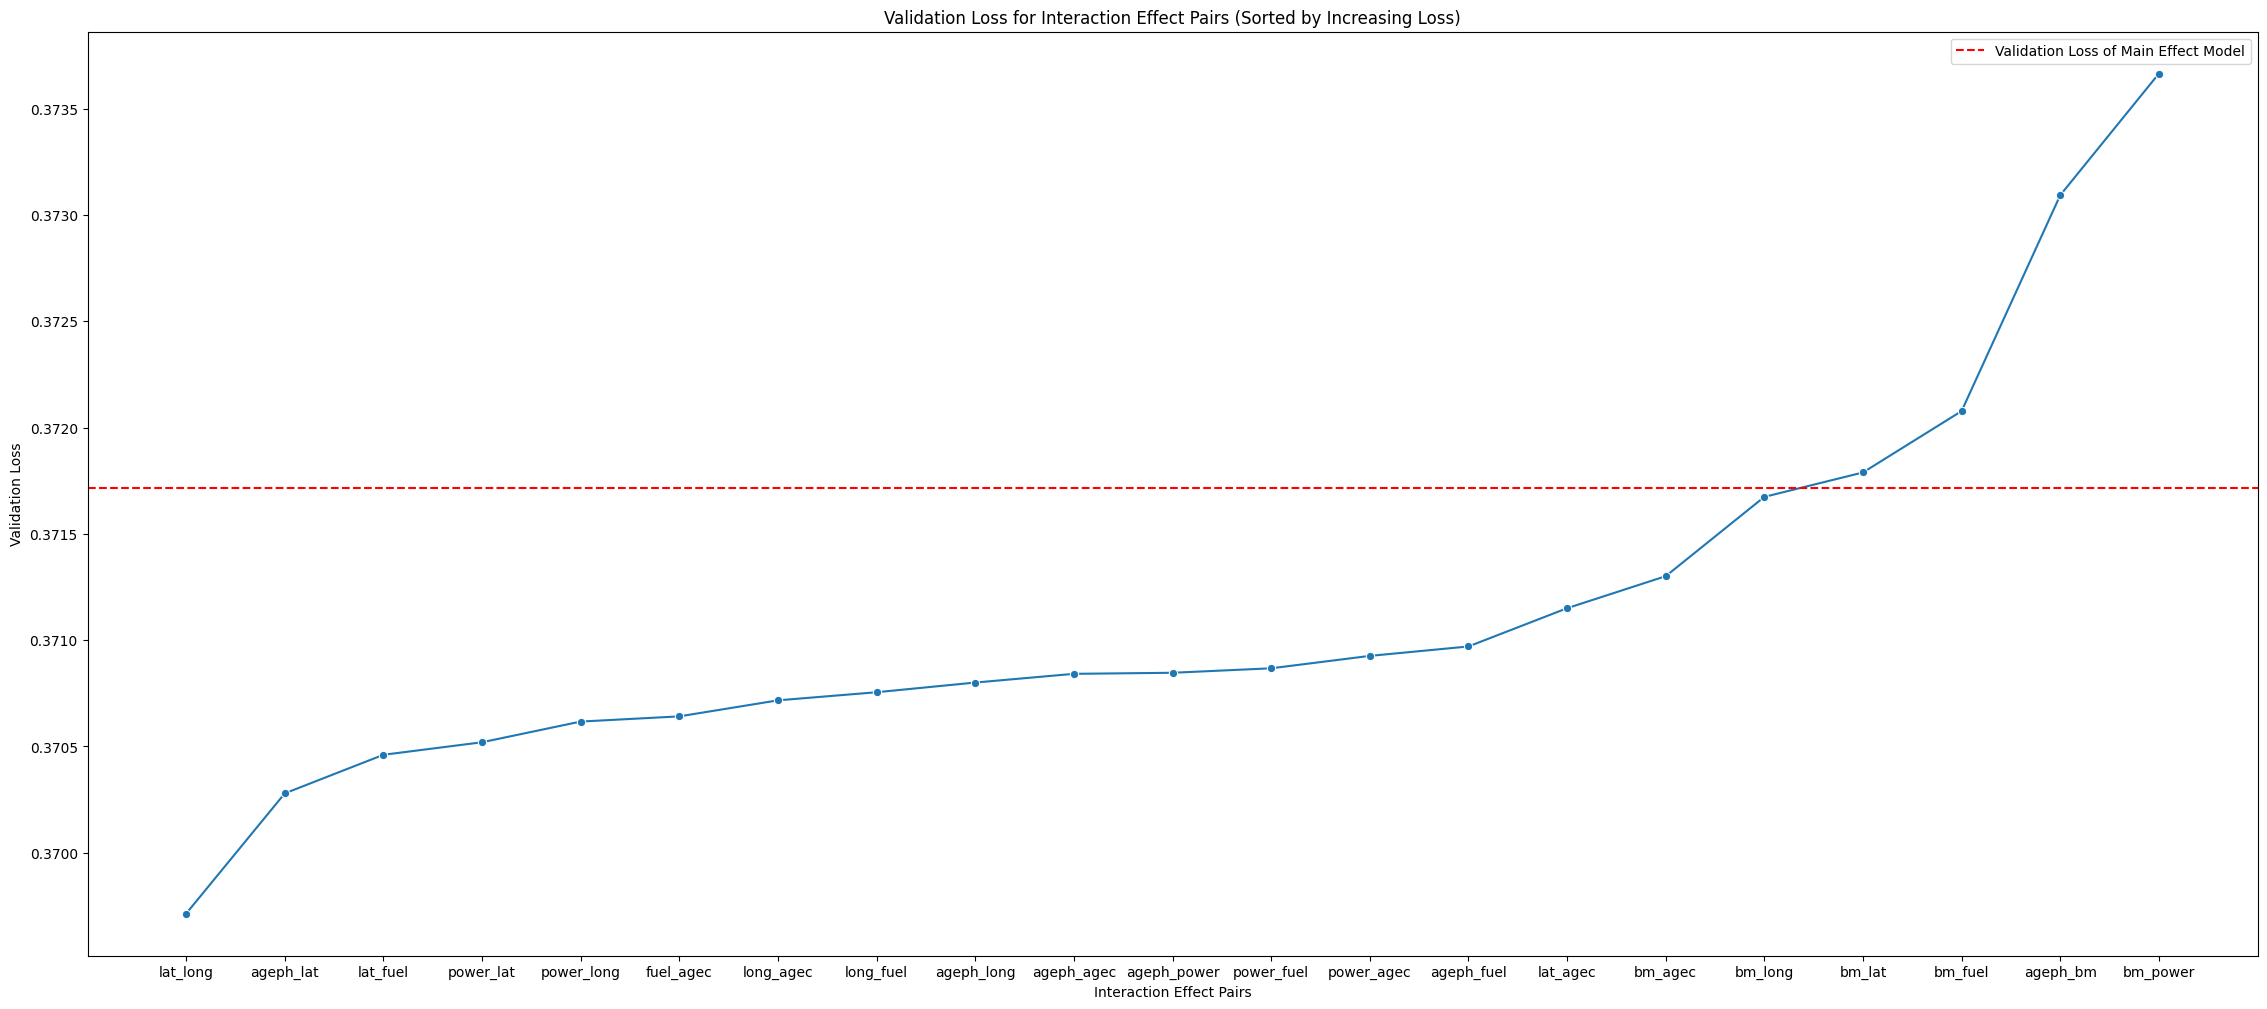

In [96]:
# -------------------------- plot the validation loss --------------------------
# Convert interaction loss dictionary to a pandas DataFrame
interaction_df = pd.DataFrame(list(interaction_loss.items()), columns = ['Interaction_Pair', 'Validation_Loss'])

# Sort the DataFrame by Validation_Loss in increasing order
interaction_df = interaction_df.sort_values(by = 'Validation_Loss', ascending = True)

# Create the bar plot using Seaborn
plt.figure(figsize = (28, 12))
sns.lineplot(x = 'Interaction_Pair', y = 'Validation_Loss', data = interaction_df, marker = 'o')
plt.axhline(main_val_loss, color = 'red', linestyle = '--', label = 'Validation Loss of Main Effect Model')
plt.xlabel('Interaction Effect Pairs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss for Interaction Effect Pairs (Sorted by Increasing Loss)')
plt.legend()
plt.show()

In [101]:
# -------------------------- define model architecture --------------------------
def build_NAM(hp):

    # -------------------- hyperpameters --------------------
    smooth_vars = ["ageph","bm","power","lat","long","agec"]
    interactions = [("lat","long"),("ageph","lat"),("lat","fuel"),("power","lat"),("power","long"),("fuel","agec"),("long","agec")]
    inputs = []  # input layers
    sub_outputs = [] # subnet output
    lattice_sizes = {} # number of vertices for each variable's lattice
    monotonicity = {"bm": "increasing"} # either increasing, decreasing, or none
    grid_length = 100 # for using finite differences with smoothness constraint
    activation = "leaky_relu"
    dropout_rate = 0
    # lambd_mc = 0
    # lambd_smooth = 0

    # hypeparameters for tuning
    num_neurons_main = hp.Int('num_neurons_main', 10, 50, step = 10) # number of neurons for main effects' subnets' hidden layers
    num_layers_main = hp.Int('num_layers_main', 2, 5) # number of hidden layers for main effects' subnets
    num_neurons_interaction = hp.Int('num_neurons_int', 20, 100, step = 20) # number of neurons for interaction effects' subnets' hidden layers
    num_layers_interaction = hp.Int('num_layers_int', 2, 10, step = 2) # number of hidden layers for interaction effects' subnets
    num_keypoints = hp.Int('num_keypoints', 10, 40, step = 10) # number of key points for lattice calibrator
    num_vertices = hp.Int('num_vertices', 2, 10, step = 2) # number of vertices for lattice layer
    lambd_mc = hp.Float('lambd_mc', min_value = 1e-5, max_value = 1e-2, sampling = 'log') # weight for marginal clarity constraint in objective function
    lambd_smooth = hp.Float('lambd_smoothness', min_value = 1e-5, max_value = 1e-1, sampling = 'log') # weight for smoothness constraint in objective function
    lr = hp.Float('learning_rate', min_value = 1e-4, max_value = 1e-2, sampling = 'log') # learning rate for optimizer
    # activation = hp.Choice('activation', ['leaky_relu', 'swish'])
    # dropout_rate = hp.Float('dropout_rate', 0, 0.3, step = 0.1)


    # add lattice size
    for var in imp_vars:
        if var in cat_vars:
            lattice_sizes[var] = X_train[var].nunique()
        else:
            lattice_sizes[var] = num_vertices


    # -------------------- main effect --------------------
    for name in ["expo"] + imp_vars:
        # input layer
        input_layer = Input(shape = (1,), name = name)
        inputs.append(input_layer)

        # subnetwork
        if name == "expo": # Direct use without a subnet
            exposure_input = input_layer
        elif name in cat_vars: # categorical variables will be one-hot encoded
            embed_layer = Embedding(input_dim = X_train[name].nunique(), 
                                    output_dim = 1, 
                                    name = f"{name}_embed")(input_layer)
            embed_layer_reshape = Reshape(target_shape = (1,), name = f"{name}_reshape")(embed_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(embed_layer_reshape)
            sub_outputs.append(mean_layer)
        elif name in monotonicity: # variables with monotonicity constraint
            calibrator_layer = tfl.layers.PWLCalibration(
                input_keypoints =  np.linspace(X_train[name].min(), X_train[name].max(), num = num_keypoints), # keypoints
                monotonicity = monotonicity[name], # monotonicity constraint
                name = f"{name}_pwlcalibrator"
            )(input_layer)
            mean_layer = BatchNormalization(scale = False, name = f"{name}_mean")(calibrator_layer)
            sub_outputs.append(mean_layer)
        else: # numeric variables
            subnet = create_subnet(num_layers_main, num_neurons_main, activation, f"{name}_subnetwork", dropout_rate)
            sub_output = subnet(input_layer)
            sub_outputs.append(sub_output)


    # -------------------- pairwise interaction effect --------------------
    for (var1, var2) in interactions:
        var1_input = inputs[imp_vars.index(var1) + 1]
        var2_input = inputs[imp_vars.index(var2) + 1]

        if any(var in monotonicity for var in [var1, var2]):
            lattice_inputs = []

            # calibrator layer
            calibrator_var1 = add_calibrate_layer(var1, var2, X_train, monotonicity, lattice_sizes, num_keypoints, cat_vars)
            calibrator_var2 = add_calibrate_layer(var2, var1, X_train, monotonicity, lattice_sizes, num_keypoints, cat_vars)
            calibrator_layer_var1 = calibrator_var1(var1_input)
            calibrator_layer_var2 = calibrator_var2(var2_input)
            
            # lattice layer
            lattice_inputs.append(calibrator_layer_var1)
            lattice_inputs.append(calibrator_layer_var2)
            lattice_layer = tfl.layers.Lattice(lattice_sizes = [lattice_sizes[var1], lattice_sizes[var2]], 
                                                monotonicities = ["increasing" if var1 in monotonicity else 'none',
                                                                "increasing" if var2 in monotonicity else 'none'],
                                                name = f"{var1}_{var2}_lattice")(lattice_inputs)
            pairwise_output = BatchNormalization(scale = False, name = f"{var1}_{var2}_mean")(lattice_layer)
            sub_outputs.append(pairwise_output)

        else: # if no monotonicity constraint is required, create a normal subnetwork
            pairwise_input_layer = Concatenate(name = f"{var1}_{var2}_concat")([var1_input, var2_input])
            pairwise_subnet = create_subnet(num_layers_interaction, 
                                            num_neurons_interaction, 
                                            activation, 
                                            f"{var1}_{var2}_subnetwork",
                                            dropout_rate)
            pairwise_dense = pairwise_subnet(pairwise_input_layer)
            sub_outputs.append(pairwise_dense)
        

    # -------------------- combine main and interaction effects --------------------
    # combine subnets' outputs
    main_subnets = Concatenate(name = "subnet_output")(sub_outputs)
    sum_output = AddSubnetOutput(activation = 'exponential',
                                    name = "sum_output")(main_subnets)
    final_output = Multiply(name = "final_output")([exposure_input, sum_output])
    model = Model(inputs = inputs, outputs = final_output)


    #-------------------------- add smoothness penalty --------------------------
    subnet_model = Model(inputs = model.inputs, outputs = main_subnets)
    for var in smooth_vars:
        penalty_function = make_smoothness_penalty(var, X_train, subnet_model, lambd_smooth, grid_length, ["expo"] + imp_vars)
        model.add_loss(penalty_function)


    #-------------------------- add marginal clarity constraint --------------------------
    for i in range(len(interactions)):
        penalty = 0
        var1 = interactions[i][0]
        var2 = interactions[i][1]
        subnet_output = model.get_layer("subnet_output").output
        main_output_var1 = subnet_output[imp_vars.index(var1)]
        main_output_var2 = subnet_output[imp_vars.index(var2)]
        interaction_output = subnet_output[len(imp_vars) + i]
        penalty = lambd_mc * (
            K.abs(K.mean(main_output_var1 * interaction_output)) +
            K.abs(K.mean(main_output_var2 * interaction_output))
        )
        # Add the penalty to the model's total loss
        model.add_loss(penalty)


    #-------------------------- compile and return the model --------------------------
    model.compile(optimizer = RMSprop(learning_rate = lr), loss = "poisson", 
                    metrics = ["poisson", RootMeanSquaredError(), MeanAbsoluteError()])

    return model

In [102]:
# -------------------------- hyperparameters of final model --------------------------
# hyperparameter tuning
tuner_NAM = kt.tuners.BayesianOptimization(
    build_NAM,
    objective = kt.Objective('val_poisson', direction = 'min'),
    max_trials = 20,
    directory = "hyperparameter_beMTPL97_NAM_test",
    seed = 0 # for reproducibility
)

# regularization
es = EarlyStopping(patience = 20, restore_best_weights = True)

# search for the best model
tuner_NAM.search(X_train_split, y_train,
            epochs = 5_000,
            batch_size = 10_000,
            validation_data = (X_val_split, y_val),
            callbacks = [es])

# get the best model
model_nam = tuner_NAM.get_best_models()[0]
tuner_NAM.results_summary(1)

Trial 20 Complete [00h 00m 27s]
val_poisson: 0.41170790791511536

Best val_poisson So Far: 0.36980170011520386
Total elapsed time: 00h 16m 04s
Results summary
Results in hyperparameter_beMTPL97_NAM_test/untitled_project
Showing 1 best trials
Objective(name="val_poisson", direction="min")

Trial 01 summary
Hyperparameters:
num_neurons_main: 50
num_layers_main: 3
num_neurons_int: 80
num_layers_int: 4
num_keypoints: 30
num_vertices: 4
lambd_mc: 3.9489864889358395e-05
lambd_smoothness: 6.682850269985957e-05
learning_rate: 0.00016271155685990062
Score: 0.36980170011520386


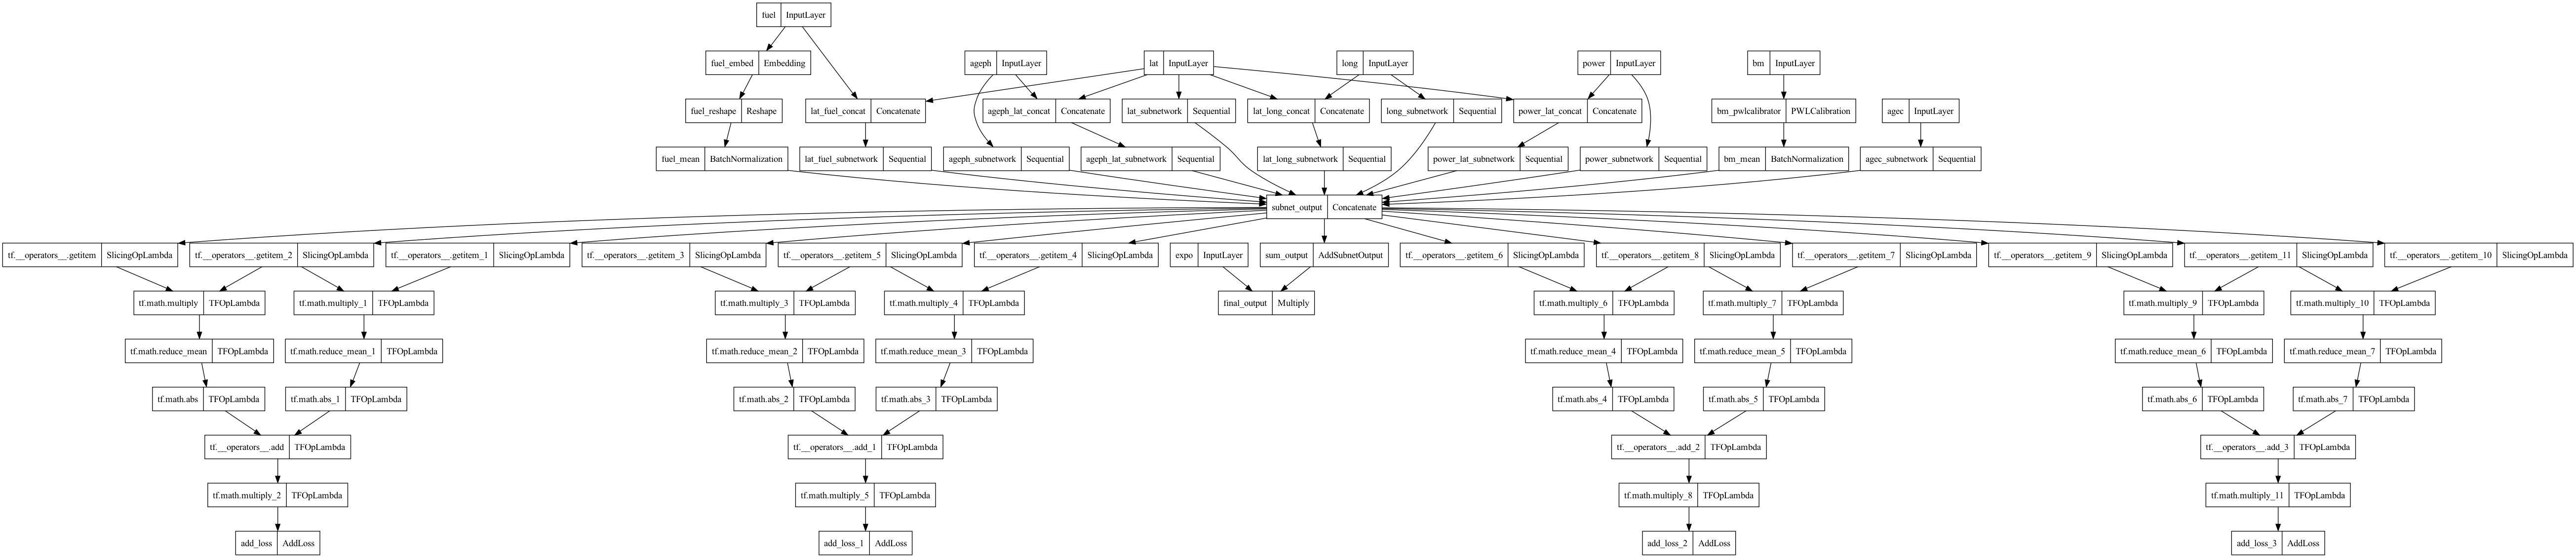

In [83]:
# plot themodel
plot_model(model_nam)

In [103]:
#-------------------------- evaluate predictive performance --------------------------
_, nam_nll, nam_rmse, nam_mae = model_nam.evaluate(X_test_split, y_test, batch_size = 10_000)
print(f"Poisson loss on test set: {nam_nll}")
print(f"RMSE on test set: {nam_rmse}")
print(f"MAE on test set: {nam_mae}")

4/4 [==============================] - 3s 17ms/step - loss: 0.3795 - poisson: 0.3793 - root_mean_squared_error: 0.3681 - mean_absolute_error: 0.2162
Poisson loss on test set: 0.379340261220932
RMSE on test set: 0.3680741488933563
MAE on test set: 0.21618172526359558


In [32]:
# # -------------------------- Create the Pairwise Only Model --------------------------
# pairwise_effect = ("ageph", "long")  # the pairwise effect we want to view
# pairwise_index = interactions.index(pairwise_effect)
# subnet_output_layer = model_nam.get_layer("subnet_output")
# subnet_model = Model(inputs = model_nam.inputs, outputs = subnet_output_layer.output)


# # -------------------------- Generate the Input Grid --------------------------
# # Create a grid of values
# grid_length = 100
# if pairwise_effect[0] in cat_vars:
#     var1_values = train
# var1_values = np.linspace(X_train[interactions[pairwise_index][0]].min(), 
#                           X_train[interactions[pairwise_index][0]].max(), 
#                           grid_length)
# var2_values = np.linspace(X_train[interactions[pairwise_index][1]].min(), 
#                           X_train[interactions[pairwise_index][1]].max(), 
#                           grid_length)

# # Create a meshgrid
# grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# # Flatten the grid
# grid_flat_var1 = grid_var1.ravel()
# grid_flat_var2 = grid_var2.ravel()


# # -------------------------- Prepare Inputs for the Model --------------------------
# grid_inputs = []
# for var in imp_vars:
#     if var == interactions[pairwise_index][0]:
#         grid_inputs.append(grid_flat_var1)
#     elif var == interactions[pairwise_index][1]:
#         grid_inputs.append(grid_flat_var2)
#     else:
#         grid_inputs.append(np.zeros_like(grid_flat_var1))


# # -------------------------- Predict Using the Pairwise-Only Model --------------------------
# # Predict the pairwise interaction effect
# pairwise_predictions = subnet_model.predict(grid_inputs)[:,len(imp_vars) + pairwise_index]

# # Reshape the predictions to the grid format
# heatmap_values = pairwise_predictions.reshape(grid_var1.shape)


# # -------------------------- Plot the Heatmap --------------------------
# plt.figure(figsize = (10, 8))
# contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10)
# plt.colorbar(contour)
# plt.title('Predicted Function by the Model')
# plt.xlabel(f"{interactions[pairwise_index][0]}")
# plt.ylabel(f"{interactions[pairwise_index][1]}")
# plt.show()

In [37]:
############################ EBM ############################
# -------------------------- define the model --------------------------
model_ebm = ExplainableBoostingRegressor(
    # interactions = [(1, 5), (5, 6), (0, 4),(0, 3), (4, 6)],
    interactions = 3,
    objective = "poisson_deviance",
    monotone_constraints = [0,1,0,0,0,0,0],
    n_jobs = -1,
    random_state = 2024
)
# Fit the model
model_ebm.fit(X_train_imp, y_train_transformed)

ExplainableBoostingRegressor(interactions=3,
                             monotone_constraints=[0, 1, 0, 0, 0, 0, 0],
                             n_jobs=-1, objective='poisson_deviance',
                             random_state=2024)

In [38]:
# -------------------------- evaluation --------------------------
ebm_pred = model_ebm.predict(X_test_imp) # get the prediction

# get metrics on test data
ebm_nll = Poisson()(y_test, ebm_pred*test[:,0]).numpy()
ebm_nll

0.38077139433924123

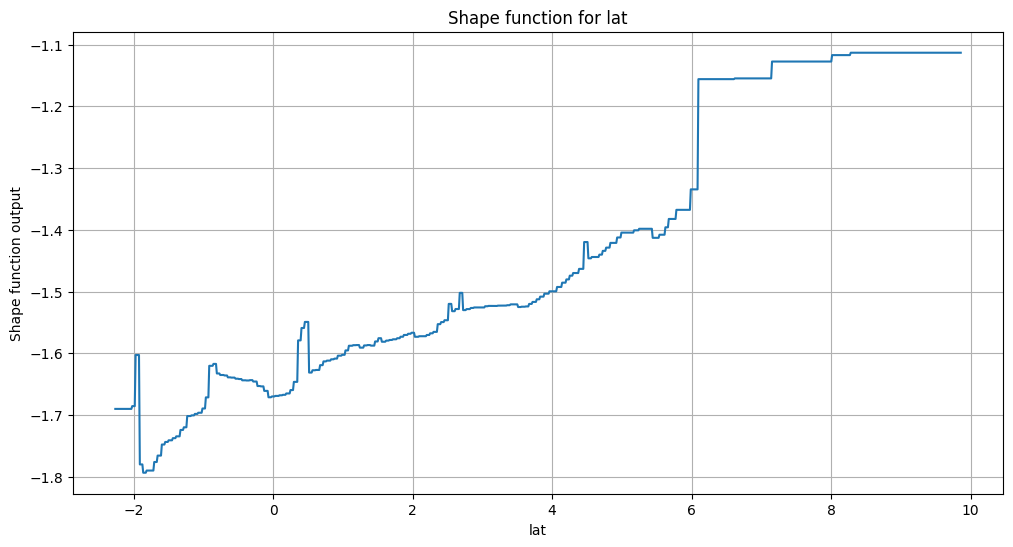

In [80]:
#-------------------------- view the shape function --------------------------
# generate input
var_name = "lat"
grid_length = 1000
grid = np.linspace(X_train_imp[:,imp_vars.index(var_name)].min(), 
                   X_train_imp[:,imp_vars.index(var_name)].max(), 
                   grid_length)
grid_inputs = []
for var in imp_vars:
    if var == var_name:
        grid_inputs.append(grid)
    else:
        grid_inputs.append(np.zeros_like(grid))
grid_inputs = np.column_stack(grid_inputs)

# get the prediction
output = np.log(model_ebm.predict(grid_inputs))

# create the plot
plt.figure(figsize = (12, 6))
sns.lineplot(x = grid, y = output)
plt.xlabel(f"{var_name}")
plt.ylabel('Shape function output')
plt.title(f"Shape function for {var_name}")
plt.grid(True)
plt.show()

In [36]:
# # -------------------------- View the heatmap --------------------------
# pairwise_effect = ("bm", "fuel")  # the pairwise effect we want to view

# # -------------------------- Generate the Input Grid --------------------------
# # Create a grid of values
# grid_length = 1000
# var1_values = np.linspace(X_train_imp[:,imp_vars.index(pairwise_effect[0])].min(),
#                           X_train_imp[:,imp_vars.index(pairwise_effect[0])].max(),
#                           grid_length)
# var2_values = np.linspace(X_train_imp[:,imp_vars.index(pairwise_effect[1])].min(), 
#                           X_train_imp[:,imp_vars.index(pairwise_effect[1])].max(), 
#                           grid_length)

# # Create a meshgrid
# grid_var1, grid_var2 = np.meshgrid(var1_values, var2_values)

# # Flatten the grid
# grid_flat_var1 = grid_var1.ravel()
# grid_flat_var2 = grid_var2.ravel()


# # -------------------------- Prepare Inputs for the Model --------------------------
# grid_inputs = []
# for var in imp_vars:
#     if var == pairwise_effect[0]:
#         grid_inputs.append(grid_flat_var1)
#     elif var == pairwise_effect[1]:
#         grid_inputs.append(grid_flat_var2)
#     else:
#         grid_inputs.append(np.zeros_like(grid_flat_var1))
# grid_inputs = np.column_stack(grid_inputs)

# # -------------------------- Predict Using the Pairwise-Only Model --------------------------
# # Predict the pairwise interaction effect
# pairwise_predictions = np.log(model_ebm.predict(grid_inputs))

# # Reshape the predictions to the grid format
# heatmap_values = pairwise_predictions.reshape(grid_var1.shape)


# # -------------------------- Plot the Heatmap --------------------------
# plt.figure(figsize = (10, 8))
# contour = plt.contourf(grid_var1, grid_var2, heatmap_values, levels = 10)
# plt.colorbar(contour)
# plt.title('Predicted Function by the Model')
# plt.xlabel(f"{pairwise_effect[0]}")
# plt.ylabel(f"{pairwise_effect[1]}")
# plt.show()

In [37]:
############################ GAM ############################

# -------------------------- define the GAM model --------------------------
model_gam = PoissonGAM(
    s(0) +
    s(1, constraints = 'monotonic_inc') +          
    s(2) +
    s(3) + 
    s(4) + 
    f(5) + 
    s(6) + 
    te(1, 5) +
    te(5, 6) +
    te(0, 4) +
    te(0, 3) + 
    te(4, 6)
)

# -------------------------- # Perform gridsearch --------------------------
model_gam.fit(X_train_imp, y_train_transformed)

did not converge


PoissonGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + f(5) + s(6) + te(1, 5) + te(5, 6) + te(0, 4) + te(0, 3) + te(4, 6) + intercept,
   tol=0.0001, verbose=False)

In [40]:
# -------------------------- evaluation --------------------------
gam_pred = model_gam.predict(X_test_imp) # get the prediction

# get metrics on test data
gam_nll = Poisson()(y_test, gam_pred*test[:,0]).numpy()
gam_nll

nan

In [39]:
# #-------------------------- view the shape function --------------------------
# # generate input
# var_name = "agec"
# grid_length = 1000
# grid = np.linspace(X_train_imp[:,imp_vars.index(var_name)].min(), 
#                    X_train_imp[:,imp_vars.index(var_name)].max(), 
#                    grid_length)
# grid_inputs = []
# for var in imp_vars:
#     if var == var_name:
#         grid_inputs.append(grid)
#     else:
#         grid_inputs.append(np.zeros_like(grid))
# grid_inputs = np.column_stack(grid_inputs)

# # get the prediction
# output = np.log(model_gam.predict(grid_inputs))

# # create the plot
# plt.figure(figsize = (12, 6))
# sns.lineplot(x = grid, y = output)
# plt.xlabel(f"{var_name}")
# plt.ylabel('Shape function output')
# plt.title(f"Shape function for {var_name}")
# plt.grid(True)
# plt.show()

In [ ]:
[("lat","long"),("ageph","lat"),("lat","fuel"),("power","lat"),("power","long"),("fuel","agec"),("long","agec")]

In [117]:
gam_column_order

['fuel', 'ageph', 'bm', 'power', 'agec', 'long', 'lat']

In [121]:
############################ GAM ############################
# -------------------------- prepare data --------------------------
train_gam = train[:,[var in imp_vars for var in all_vars]] 
val_gam = val[:,[var in imp_vars for var in all_vars]] 
test_gam = test[:,[var in imp_vars for var in all_vars]] 
gam_column_order = [var for var in all_vars if var in imp_vars]

# -------------------------- define the GAM model --------------------------
model_gam = PoissonGAM(
    f(0) +
    s(1) +
    s(2, constraints = 'monotonic_inc') + 
    s(3) +
    s(4) +
    s(5) +
    s(6) +
    te(5, 6) +
    te(1, 6) +
    s(6, by = 0) +
    te(3, 6)
)

# -------------------------- define hyperparameter for tuning --------------------------
# Define the hyperparameter grid
lam_values = [0.001, 0.01, 0.1, 1]
n_splines_values = [5, 10, 15, 20]

# -------------------------- # Perform gridsearch --------------------------
model_gam.gridsearch(train_gam,y_train/train[:,0], lam = lam_values, n_splines = n_splines_values)
# model_gam.fit(train_gam,y_train/train[:,0])

  0% (0 of 16) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


  6% (1 of 16) |#                        | Elapsed Time: 0:06:28 ETA:   1:37:00


KeyboardInterrupt: 

In [120]:
# -------------------------- evaluation --------------------------
gam_pred = model_gam.predict(test_gam) # get the prediction

# get metrics on test data
gam_nll = Poisson()(y_test, gam_pred*test[:,0]).numpy()
gam_nll

0.3824324890185166